# APMTH 207: Advanced Scientific Computing: 
## Stochastic Methods for Data Analysis, Inference and Optimization
## Homework #6
**Harvard University**<br>
**Spring 2017**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Thursday, March 9th, 2017 at 11:59pm

**Instructions:**

- Upload your final answers as well as your iPython notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

In [25]:
%matplotlib inline
import numpy as np
import scipy as sp
from scipy.stats import uniform
from scipy.stats import gamma
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.graphics import tsaplots
from functools import partial

## Problem 1: Gibbs Sampling

Let $\mathbf{X}$ be a random variable taking values in $\mathbb{R}^2$. That is, $\mathbf{X}$ is a 2-dimensional vector. Suppose that $\mathbf{X}$ is normally distributed as follows
$$ 
\mathbf{X} \sim \mathcal{N} \left(  
\left[
\begin{array}{c}
    1  \\ 
    2  \\ 
  \end{array} 
\right],
\left[
  \begin{array}{ccc}
    4 & 1.2  \\ 
    1.2 & 4 \\ 
  \end{array} 
  \right] \right).
$$ 
That is, the pdf of the distribution of $\mathbf{X}$ is
$$
f_{\mathbf{X}}(\mathbf{x}) = \frac{1}{2\pi\sqrt{\vert \Sigma\vert }}\mathrm{exp}\left\{ - \frac{1}{2} (\mathbf{x} - \mu)^\top \Sigma^{-1} (\mathbf{x} - \mu)\right\}
$$
where $\mu = \left[
\begin{array}{c}
    1  \\ 
    2  \\ 
  \end{array} 
\right]$, $\Sigma = \left[
  \begin{array}{ccc}
    4 & 1.2  \\ 
    1.2 & 4 \\ 
  \end{array} 
  \right]$, and $\vert \cdot\vert $ is the matrix determinant operator.

In the following, we will denote the random variable corresponding to the first component of $\mathbf{X}$ by $X_1$ and the second component by $X_2$.

### Part A:
Write the Gibbs sampler for this distribution by sampling sequentially from the two conditional distributions $f_{X_1\vert X_2}, f_{X_2\vert X_1}$. Choose a thinning parameter, burn-in factor and total number of iterations that allow you to take 10000 non-autocorrelated draws. You must justify your choice of parameters. 

**Solutions:**
Let's denote the first component, $X_1$, of $\mathbf{X}$, by $X$ and the second component, $X_2$, by $Y$.

Now, if $X$ and $Y$ are jointly normally distributed with $\mu = [\mu_X, \mu_Y]$ and $\Sigma = \left[\begin{array}{cc}\sigma^2_X & \rho\sigma_X\sigma_Y\\\rho\sigma_X\sigma_Y & \sigma^2_Y\end{array}\right]$. The conditionals $p(Y | X) = f_{Y\vert X}$ and $p(X | Y) = f_{X\vert Y}$ are both normal with:
\begin{align}
\mathbb{E}[Y|x] &= \mu_Y + \rho\frac{\sigma_Y}{\sigma_X}(X - \mu_X), &\text{Var}[Y|x] = \sigma_Y^2(1 - \rho)\\
\mathbb{E}[X|y] &= \mu_X + \rho\frac{\sigma_X}{\sigma_Y}(Y - \mu_Y), &\text{Var}[X|y] = \sigma_X^2(1 - \rho)
\end{align}
***Note:*** The derivation of these forms are algebraically involved but not difficult, we encourage you to do it by hand once (following online notes if you'd like) to get a flavor of how to manipulate Gaussian distributions.

In our case, we see that we have $\mu_X = 1, \mu_Y = 2$, $\sigma_X = \sigma_Y = 2$. Then we have $\rho = \frac{\text{Cov}[X, Y]}{\sigma_X\sigma_Y} = \frac{1.2}{4} = 0.3$.

Finally, we have that our two conditionals are:

\begin{align}
p(Y | X) &= \mathcal{N}\left( \mu_Y + \rho\frac{\sigma_Y}{\sigma_X}(X - \mu_X), \sigma_Y^2(1 - \rho)\right)\\
p(X | Y) &= \mathcal{N}\left( \mu_X + \rho\frac{\sigma_X}{\sigma_Y}(Y - \mu_Y), \sigma_X^2(1 - \rho) \right)
\end{align}

Our Gibbs Sampling will consists of repeating the following two steps:

- Draw $Y$ from $p(Y | x)$
- Draw $X$ from $p(X| y)$

In [4]:
#Defining all the parts in the bivariate normal distribution
sigma_x = 2
sigma_y = 2
rho = 0.3
mu_x = 1
mu_y = 2

p_x_given_y = lambda y: np.random.normal(mu_x + rho * sigma_x / sigma_y * (y - mu_y), sigma_x**2 * (1 - rho), 1)[0]
p_y_given_x = lambda x: np.random.normal(mu_y + rho * sigma_y / sigma_x * (x - mu_x), sigma_y**2 * (1 - rho), 1)[0]

def gibbs(p_x_given_y, p_y_given_x, iters, x_0, y_0, burn, thin=1):
    samples = [(x_0, y_0)]
    
    for i in range(iters):
        new_x = p_x_given_y(samples[-1][1])
        new_y = p_y_given_x(samples[-1][0])
        samples.append([new_x, new_y])
        
    return np.array(samples[int(burn * iters)::thin])

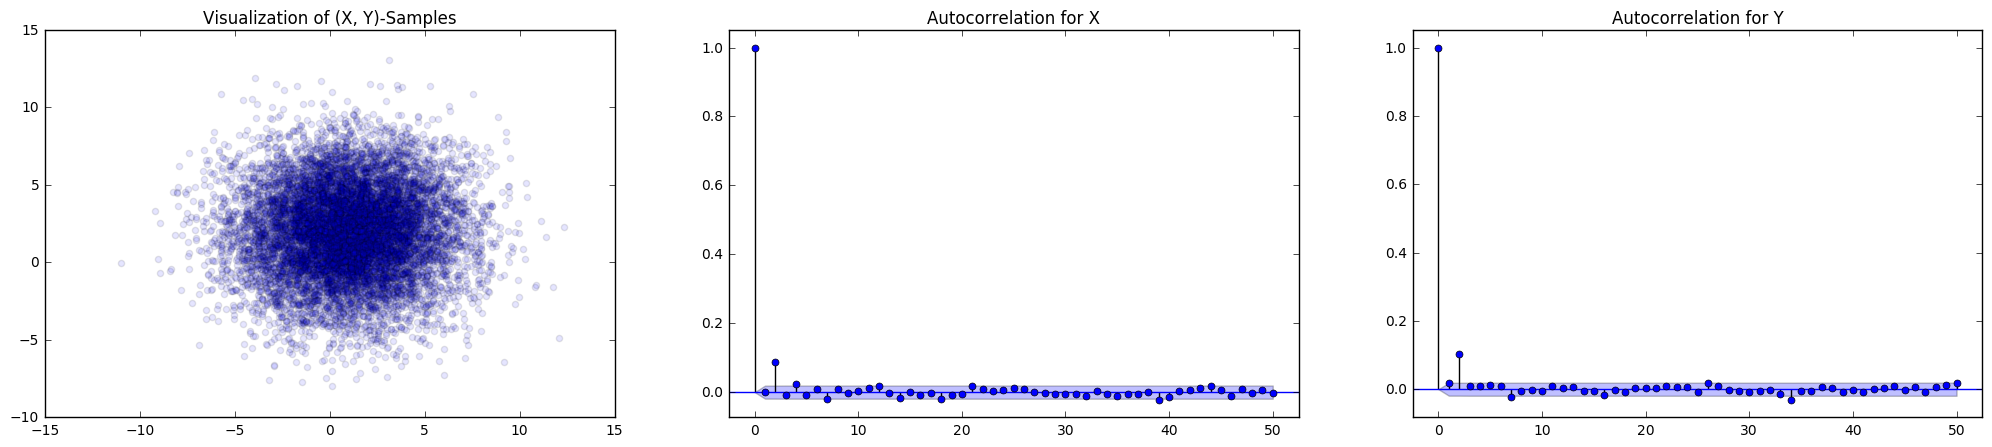

In [23]:
x_0 = 0
y_0 = 0
iters = 12000
burn = .1
samples = gibbs(p_x_given_y, p_y_given_x, iters, x_0, y_0, burn)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5))

ax1.scatter(samples[:, 0], samples[:, 1], alpha=0.1)
ax1.set_title('Visualization of (X, Y)-Samples')

tsaplots.plot_acf(samples[:, 0], ax2, 50)
ax2.set_title('Autocorrelation for X')

tsaplots.plot_acf(samples[:, 1], ax3, 50)
ax3.set_title('Autocorrelation for Y')
plt.show()


## Problem 2: Bayesian Inference and All That
In the competitive rubber chicken retail market, the success of a company is built on satisfying the exacting standards of a consumer base with refined and discriminating taste. In particular, customer product reviews are all important. But how should we judge the quality of a product based on customer reviews?

On Amazon, the first customer review statistic displayed for a product is the ***average rating***. The following are the main product pages for two competing rubber chicken products, manufactured by Lotus World and Toysmith respectively:


Lotus World |  Toysmith
- |  - 
![alt](lotus1.png) |  ![alt](toysmith1.png)

Clicking on the 'customer review' link on the product pages takes us to a detailed break-down of the reviews. In particular, we can now see the number of times a product is rated a given rating (between 1 and 5 stars).

Lotus World |  Toysmith
- |  - 
![alt](lotus2.png) |  ![alt](toysmith2.png)


In the following, we will ask you to compare these two products using the various rating statistics. Larger versions of the images are available in the data set accompanying this notebook.

Suppose that for each product, we can model the probability of the value each new rating as the following vector:
$$
\theta = [\theta_1, \theta_2, \theta_3, \theta_4, \theta_5]
$$
where $\theta_i$ is the probability that a given customer will give the product $i$ number of stars.


### Part A: Inference

- Suppose you are told that customer opinions are very polarized in the retail world of rubber chickens, that is, most reviews will be 5 stars or 1 stars (with little middle ground). Choose an appropriate Dirichlet prior for $\theta$. Recall that the Dirichlet pdf is given by:
$$
f_{\Theta}(\theta) = \frac{1}{B(\alpha)} \prod_{i=1}^k \theta_i^{\alpha_i - 1}, \quad B(\alpha) = \frac{\prod_{i=1}^k\Gamma(\alpha_i)}{\Gamma\left(\sum_{i=1}^k\alpha_i\right)},
$$
where $\theta_i \in (0, 1)$ and $\sum_{i=1}^k \theta_i = 1$, $\alpha_i > 0 $ for $i = 1, \ldots, k$.

- Write an expression for the posterior pdf, using a using a multinomial model for observed ratings. Recall that the multinomial pdf is given by:
$$
f_{\mathbf{X}\vert  \Theta}(\mathbf{x}) = \frac{n!}{x_1! \ldots x_k!} \theta_1^{x_1} \ldots \theta_k^{x_k}
$$
where $n$ is the total number of trials, $\theta_i$ is the probability of event $i$ and $\sum_i \theta_i = 1$, and $x_i$ is count of outcome $i$ and $\sum_i x_i = n$. 

  **Note:** The data you will need in order to define the likelihood function should be read off the image files included in the dataset.
  

- Sample 1,000 values of $\theta$ from the *posterior distribution*.
 
- Sample 1,000 values of $x$ from the *posterior predictive distribution*.


**Solutions:**
The Bayesian model for each product is as follows:
\begin{aligned}
p(\theta) &= \text{Dirichlet}(\theta; \alpha)\\
p(X|\theta)&= \text{Multinomial}(X; n, \theta)
\end{aligned}
where $\theta = [\theta_1, \theta_2, \theta_3, \theta_4, \theta_5]$, $\alpha = [\alpha_1, \alpha_2, \alpha_3, \alpha_4, \alpha_5]$ and $X = [X_1, X_2, X_3, X_4, X_5]$. Each $X_i$ is the number of times the product is given $i$-number of stars, each $\theta_i$ is the "likelihood" that any customer will give the product $i$-number of stars, and $\alpha_i$ is the hyperparameter controlling the "likelihood" that a larger value for $\theta_i$ is drawn.

This model models two parts:

1. In the prior, $p(\theta)$, we assume that each product has a secret quality rating - this is a distribution over 1 thru 5 stars (for example, [1, 0, 0, 0, 0] might indicate that the product isn't very good). This quality rating is unknown to us (we only see what the actual customer). The prior represents what we believe the secret quality rating to be. So, for example, $\alpha = [1000, 1, 1, 1, 1]$ represents the (very strong) belief that the quality rating for this product is very likely to be concentrated at 1-star (more specifically, when $\alpha >0$ it represents a vector of pseudo-counts, as if this these are ratings you already have prior to collecting your data).

2. The likelihood describes the data we actually see (i.e. the counts, how many 5 star ratings and how many 4 star ratings etc). Here, we assume that each customer reviews the product independently, and, furthermore, the way they do it is based on the "secret quality rating", $\theta$. That is, if the secret rating of the product is $[.9, 0, 0, 0, .1]$, then there is a 90% chance that any customer will rank the product 1-star and a 10% chance that they will rank it 5 stars. Thus, each customer review is a mulinoulli or categorical trial and the total review data (the counts) can be described as a multinomial model.

So, since apparently the rubber chicken is a polarizing product, we'll choose the following alphas for our prior: $\alpha = [1000, 10, 10, 10, 1000]$. Note that, this is a pretty strong belief (as opposed to $\alpha = [10, 9, 9, 9, 10]$).

Both the posterior and the posterior predictive distributions have closed forms that can be analytically derived. The derivation is algebraically involved but not difficult. We recommend that you try the derivation once (with online notes if you'd like) just to get a flavor of how to work with conjugate models.

The posterior distribution for this Multinomial-Dirichlet model is a Dirichlet distribution, with 

$$\alpha_{posterior} = [\alpha_1 + \text{number of 1 stars}, ..., \alpha_5 + \text{number of 5 stars}]$$ 

The posterior predictive is a multimoulli/categorical trial, with 

$$\theta_i = \frac{\text{(number of i stars)} + \alpha_i}{\sum_k\text{(number of k stars)} + \alpha_k }.$$

To sample from Dirichlet is easy, we can simply ask `numpy` to do it. 

To sample from posterior predictive, you have two choices:
 
- feed the each posterior samples of $\theta$ into the likelihood, then draw an $X$ from the likelihood
- sample $X$'s directly from the categorical class probabilities described in the above

We'll implement the method of sampling where we simulate the posterior predictive using posterior samples, since you will need this type of sampling in later homework assignments.

To summarize the posterior samples of $\theta$ into a single usable quality rating for each product, we will take the mean of the posterior samples. Note that you can also take the mode or some percentile.

To summarize the samples from the posterior predictive, we will also take the mean. Again, you might wish to take the mode, or some percentile. These means will give us another estimation of the quality rating of each product.

In [27]:
#hyper parameters for the Dirichlet prior
alpha = [10000, 10, 10, 10, 10000]
#the data for lotus
counts_lotus = [109, 27, 10, 6, 10]
n_lotus = 162
#the data for toysmith
n_toysmith = 410
counts_toysmith = [246, 45, 29, 33, 57]

posterior_samples_lotus = np.random.dirichlet(np.array(alpha) + np.array(counts_lotus), 1000)
posterior_mean_lotus = posterior_samples_lotus.mean(axis=0)
print 'lotus posterior mean:', posterior_mean_lotus

posterior_samples_ts = np.random.dirichlet(np.array(alpha) + np.array(counts_toysmith), 1000)
posterior_mean_ts = posterior_samples_ts.mean(axis=0)
print 'toysmith posterior mean:', posterior_mean_ts

lotus posterior mean: [ 0.50067093  0.00185412  0.0009905   0.00078527  0.49569917]
toysmith posterior mean: [ 0.50133174  0.00271647  0.00190055  0.00212515  0.4919261 ]


In [35]:
def multinomial_draw(thetas, n):
    return np.random.multinomial(n, thetas, size=1) * 1. / n
    
predictive_samples_lotus = map(partial(multinomial_draw, n=n_lotus), posterior_samples_lotus)
posterior_pred_mean_lotus = np.mean(predictive_samples_lotus, axis=0)
print 'lotus posterior predictive mean:', posterior_pred_mean_lotus

predictive_mean_ts = map(partial(multinomial_draw, n=n_toysmith), posterior_samples_ts)
posterior_pred_mean_ts = np.mean(predictive_mean_ts, axis=0)
print 'toysmith posterior predictive mean:', posterior_pred_mean_ts

lotus posterior predictive mean: [[ 0.49788272  0.00194444  0.00096296  0.00087037  0.49833951]]
toysmith posterior predictive mean: [[ 0.50057805  0.00281951  0.00176585  0.00213902  0.49269756]]


Notice that the quality ratings produced from both the posterior and posterior predictive distributions are very similar. Note also that this will not be the case in every application.

### Part B: Ranking

- Name at least two major potential problems with using only the average customer ratings to compare products.

  (**Hint:** if product 1 has a higher average rating than product 2, can we conclude that product 1 is better liked? If product 1 and product 2 have the same average rating, can we conclude that they are equally good?)
  

- Using the samples from your *posterior distribution*, determine which rubber chicken product is superior. Justify your conclusion with sample statistics.

- Using the samples from your *posterior predictive distribution*, determine which rubber chicken product is superior. Justify your conclusion with sample statistics.

- Finally, which rubber chicken product is superior?

  (**Note:** we're not looking for "the correct answer" here, any sound decision based on a statistically correct interpretation of your model will be fine)
  
**Solutions:**

There are two immediate issues with using an "average star rating" to rank products:

1. An average star rating can obscure the difference between a mediocre product (one that receives 100 two or three star reviews) and a polarizing product (one that receives 50 five star reviews and 50 one star reviews). We can, no doubt, all think of instances where distinguishing between a mediocre product and a polarizing product makes all the difference in the world (to consumers).

2. Another problem with averaging star ratings is a general statistical weakness of using averages to rate things. We've seen this problem pop up in many previous examples, when small sample sizes heavily skew averages towards extreme values.

Adding a prior to our model, in effect, regularizes our quality rating estimates. For example, from the actual customer ratings, we see that Lotus has a 67% five star rating (and a 17% four star rating), whereas Toysmith only has a 60% five star rating (and a 11% four star rating). This might lead you to believe that Lotus makes a finer rubber chicken than Toysmith. However, note that Lotus only has 160 reviews while Toysmith has nearly three times as many. One might conjecture that Lotus has simply gotten lucky by draw a handful of very easily pleased customers.

On the other hand, in both quality estimates obtained from our Bayesian model Lotus and Toysmith have very similar quality ratings distributions. That is, using our estimates obtained form the Bayesian model we would conclude that Lotus and Toysmith make comparable products.

Note that our posterior and posterior predictive estimate depend on our choice of parameters for the prior. We encourage you to experiment with some different choices of $\alpha$, and observe the effect of your choices on the quality rating estimates.